In [24]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
%autoreload 2

In [26]:
import matplotlib.pyplot as plt
import uproot_methods

In [27]:
import libwwz

In [28]:
import uproot
import os
import numpy as np
import pandas as pd

In [29]:
from geeksw.utils.core import concatenate
from geeksw.utils.data_loader_tools import make_data_loader, TreeWrapper, list_root_files_recursively

In [30]:
import pyarrow.parquet as pq
import pandas as pd

In [31]:
_dataset = pq.ParquetDataset("/home/llr/cms/rembser/WWZ-leptonic-EFT-analysis/skims/2017_WWZ_four_lepton_skim/parquet")
df_full = _dataset.read_pandas().to_pandas()
#nano_event = _df["evt"].values

In [32]:
def passes_Z_id(df):
    df_out = pd.DataFrame()
    for i in range(4):
        base_selection = df[f"VetoLepton_ip3d_{i}"].abs() / df[f"VetoLepton_sip3d_{i}"] < 4
        
        is_ele = df[f"VetoLepton_pdgId_{i}"].abs() == 11
        is_mu = df[f"VetoLepton_pdgId_{i}"].abs() == 13
        
        electron_selection = df[f"VetoLepton_pfRelIso03_all_wLep_{i}"] < 0.2
        
        muon_selection = df[f"VetoLepton_mediumId_{i}"] & df[f"VetoLepton_pfRelIso03_all_wLep_{i}"] < 0.25
        
        selection = base_selection & ((is_ele & electron_selection) | (is_mu & muon_selection))
        
        df_out[f"VetoLepton_passesZid_{i}"] = selection
    return df_out

In [33]:
def passes_W_id(df):
    df_out = pd.DataFrame()
    for i in range(4):
        base_selection = df[f"VetoLepton_ip3d_{i}"].abs() / df[f"VetoLepton_sip3d_{i}"] < 4
        
        is_ele = df[f"VetoLepton_pdgId_{i}"].abs() == 11
        is_mu = df[f"VetoLepton_pdgId_{i}"].abs() == 13
        
        electron_selection = df[f"VetoLepton_mediumId_{i}"] & df[f"VetoLepton_pfRelIso03_all_wLep_{i}"] < 0.2
        
        muon_selection = df[f"VetoLepton_mediumId_{i}"] & df[f"VetoLepton_pfRelIso03_all_wLep_{i}"] < 0.15
        
        selection = base_selection & ((is_ele & electron_selection) | (is_mu & muon_selection))
        
        df_out[f"VetoLepton_passesWid_{i}"] = selection
    return df_out

474.14386

In [187]:
def jagged_pair_masses(df):
    import awkward
    content = df[["VetoLeptonPair_mass_01", "VetoLeptonPair_mass_02", "VetoLeptonPair_mass_03", 
               "VetoLeptonPair_mass_12", "VetoLeptonPair_mass_13", "VetoLeptonPair_mass_23"]].values.flatten()
    
    return awkward.JaggedArray.fromcounts(6 + np.zeros(len(df), dtype=np.int), content)

In [53]:
def jagged_lepton_variable(df, variable):
    import awkward
    content = df[[f"VetoLepton_{variable}_0",
                 f"VetoLepton_{variable}_1",
                 f"VetoLepton_{variable}_2",
                 f"VetoLepton_{variable}_3"]].values.flatten()
    
    return awkward.JaggedArray.fromcounts(4 + np.zeros(len(df), dtype=np.int), content)

In [54]:
jagged_lepton_variable(df, "pt")

<JaggedArray [[139.17367553710938 99.70079803466797 78.56649780273438 22.383941650390625] [342.103271484375 128.05360412597656 36.159324645996094 10.100736618041992] [189.14801025390625 70.32777404785156 31.609167098999023 10.948343276977539] ... [251.69728088378906 158.0769500732422 66.212158203125 16.047008514404297] [73.38579559326172 62.21168518066406 17.38884925842285 12.272255897521973] [66.70853424072266 45.80470657348633 39.04925537109375 31.180017471313477]] at 0x7f3f04089b70>

In [77]:
def to_singleton_jagged_array(arr):
    import awkward
    return awkward.JaggedArray.fromcounts(np.ones(len(arr), dtype=np.int), arr)

In [208]:
def find_boson_candidate_indices(df):
    z_mass = 91.19

    def find_z_candidates(df):

        df_out = pd.DataFrame()

        for i in range(4):
            for j in range(4):
                if j <= i:
                    continue
                mass = df[f"VetoLeptonPair_mass_{i}{j}"].copy().values
                mass[df[f"VetoLepton_pdgId_{i}"] + df[f"VetoLepton_pdgId_{j}"] != 0] = np.nan
                mass[~df[f"VetoLepton_passesZid_{i}"]] = np.nan
                mass[~df[f"VetoLepton_passesZid_{j}"]] = np.nan

                pt_i = df[f"VetoLepton_pt_{i}"]
                pt_j = df[f"VetoLepton_pt_{j}"]
                mass[np.max([pt_i, pt_j], axis=0) < 25] = np.nan
                mass[np.min([pt_i, pt_j], axis=0) < 10] = np.nan

                df_out[f"VetoLeptonPair_z_cand_mass_{i}{j}"] = mass

        return df_out

    z_df = find_z_candidates(df)

    def z_idx_to_lep_idx(z_idx):
        lep_1_idx = 0 + (z_idx > 2)
        lep_2_idx = z_idx + 1

        lep_1_idx = lep_1_idx + (z_idx > 4)

        lep_2_idx[z_idx == 2] = 3
        lep_2_idx[z_idx == 3] = 2
        lep_2_idx[z_idx == 4] = 3
        lep_2_idx[z_idx == 5] = 3
        
        lep_1_idx[z_idx < 0] = -99
        lep_2_idx[z_idx < 0] = -99

        return lep_1_idx, lep_2_idx

    has_z_cand = ~(np.sum(~np.isnan(z_df.values), axis=1) == 0)

    in_z_window = has_z_cand[:]
    in_z_window[has_z_cand] = np.nanmin(np.abs(z_df[has_z_cand].values - z_mass), axis=1) < 10.0
    z_idx = np.nanargmin(np.abs(z_df[in_z_window].values - z_mass), axis=1)

    w_lep_1_idx = np.zeros(len(df), dtype=np.int) - 99
    w_lep_2_idx = np.zeros(len(df), dtype=np.int) - 99

    z_lep_1_idx = np.zeros(len(df), dtype=np.int) - 99
    z_lep_2_idx = np.zeros(len(df), dtype=np.int) - 99

    a, b = z_idx_to_lep_idx(z_idx)
    z_lep_1_idx[in_z_window] = a
    z_lep_2_idx[in_z_window] = b

    w_lep_1_idx[np.logical_and(z_lep_1_idx == 0, z_lep_2_idx == 1)] = 2
    w_lep_1_idx[np.logical_and(z_lep_1_idx == 0, z_lep_2_idx == 2)] = 1
    w_lep_1_idx[np.logical_and(z_lep_1_idx == 0, z_lep_2_idx == 3)] = 1
    w_lep_1_idx[np.logical_and(z_lep_1_idx == 1, z_lep_2_idx == 2)] = 0
    w_lep_1_idx[np.logical_and(z_lep_1_idx == 1, z_lep_2_idx == 3)] = 0
    w_lep_1_idx[np.logical_and(z_lep_1_idx == 2, z_lep_2_idx == 3)] = 0

    w_lep_2_idx[np.logical_and(z_lep_1_idx == 0, z_lep_2_idx == 1)] = 3
    w_lep_2_idx[np.logical_and(z_lep_1_idx == 0, z_lep_2_idx == 2)] = 3
    w_lep_2_idx[np.logical_and(z_lep_1_idx == 0, z_lep_2_idx == 3)] = 2
    w_lep_2_idx[np.logical_and(z_lep_1_idx == 1, z_lep_2_idx == 2)] = 3
    w_lep_2_idx[np.logical_and(z_lep_1_idx == 1, z_lep_2_idx == 3)] = 2
    w_lep_2_idx[np.logical_and(z_lep_1_idx == 2, z_lep_2_idx == 3)] = 1
    
    # Don't consider W-leptons if they don' pass the ID
    passes_w_id = jagged_lepton_variable(df, "passesWid")[in_z_window]
    jagged_w_lep_1_idx_in_z_window = to_singleton_jagged_array(w_lep_1_idx[in_z_window])
    jagged_w_lep_2_idx_in_z_window = to_singleton_jagged_array(w_lep_2_idx[in_z_window])
    passes = np.logical_and(passes_w_id[jagged_w_lep_1_idx_in_z_window],
                            passes_w_id[jagged_w_lep_2_idx_in_z_window]).flatten()
    passes_all = np.array(in_z_window)
    passes_all[in_z_window] = passes
    w_lep_1_idx[~passes_all] = -99
    w_lep_2_idx[~passes_all] = -99
    
    # Don't consider W-leptons if they are not opposite charge
    w_lep_charge = np.sign(jagged_lepton_variable(df, "pdgId"))[in_z_window]
    w_charge_1 = w_lep_charge[jagged_w_lep_1_idx_in_z_window].flatten()
    w_charge_2 = w_lep_charge[jagged_w_lep_2_idx_in_z_window].flatten()
    passes = w_charge_1 + w_charge_2 == 0
    passes_all = np.array(in_z_window)
    passes_all[in_z_window] = passes
    w_lep_1_idx[~passes_all] = -99
    w_lep_2_idx[~passes_all] = -99
    
    # W candidate pt cuts
    w_cand_pt = jagged_lepton_variable(df, "pt")[in_z_window]
    w_pt_1 = w_cand_pt[jagged_w_lep_1_idx_in_z_window].flatten()
    w_pt_2 = w_cand_pt[jagged_w_lep_2_idx_in_z_window].flatten()
    passes = np.logical_and(np.max([w_pt_1, w_pt_2], axis=0) > 25,
                            np.min([w_pt_1, w_pt_2], axis=0) > 10)

    passes_all = np.array(in_z_window)
    passes_all[in_z_window] = passes
    w_lep_1_idx[~passes_all] = -99
    w_lep_2_idx[~passes_all] = -99

    return pd.DataFrame(dict(z_lep_1_idx=z_lep_1_idx, z_lep_2_idx=z_lep_2_idx,
                             w_lep_1_idx=w_lep_1_idx, w_lep_2_idx=w_lep_2_idx))

In [209]:
cands_idx

,z_lep_1_idx,z_lep_2_idx,w_lep_1_idx,w_lep_2_idx
0,0,3,1,2
1,-99,-99,-99,-99
2,0,3,-99,-99
3,0,3,-99,-99
4,-99,-99,-99,-99
...,...,...,...,...
776026,0,1,2,3
776027,0,2,-99,-99
776028,-99,-99,-99,-99
776029,0,1,-99,-99


In [210]:
def lep_idx_to_z_idx(z_lep_1_idx, z_lep_2_idx):
    z_idx = np.zeros(len(z_lep_1_idx), dtype=np.int) - 99
    
    z_idx[np.logical_and(z_lep_1_idx == 0, z_lep_2_idx == 1)] = 0
    z_idx[np.logical_and(z_lep_1_idx == 0, z_lep_2_idx == 2)] = 1
    z_idx[np.logical_and(z_lep_1_idx == 0, z_lep_2_idx == 3)] = 2
    z_idx[np.logical_and(z_lep_1_idx == 1, z_lep_2_idx == 2)] = 3
    z_idx[np.logical_and(z_lep_1_idx == 1, z_lep_2_idx == 3)] = 4
    z_idx[np.logical_and(z_lep_1_idx == 2, z_lep_2_idx == 3)] = 5
    
    return z_idx

In [217]:
def get_z_cand_masses(df):
    has_z_cand_1 = df["z_lep_1_idx"] >= 0
    has_z_cand_2 = df["w_lep_1_idx"] >= 0
    
    z_lep_1_idx = df["z_lep_1_idx"][has_z_cand_1].values
    z_lep_2_idx = df["z_lep_2_idx"][has_z_cand_1].values
    w_lep_1_idx = df["w_lep_1_idx"][has_z_cand_2].values
    w_lep_2_idx = df["w_lep_2_idx"][has_z_cand_2].values
    
    pair_masses = jagged_pair_masses(df)
    
    z_cand_1_mass = pair_masses[has_z_cand_1][to_singleton_jagged_array(lep_idx_to_z_idx(z_lep_1_idx, z_lep_2_idx))]
    z_cand_2_mass = pair_masses[has_z_cand_2][to_singleton_jagged_array(lep_idx_to_z_idx(w_lep_1_idx, w_lep_2_idx))]
    
    lep_pdg_id = jagged_lepton_variable(df, "pdgId")[has_z_cand_2]
    w_pdg_1 = lep_pdg_id[to_singleton_jagged_array(w_lep_1_idx)]
    w_pdg_2 = lep_pdg_id[to_singleton_jagged_array(w_lep_2_idx)]
    
    z_cand_2_mass[w_pdg_1 + w_pdg_2 != 0] = np.nan

    df_out = pd.DataFrame(index=df.index)
    df_out.loc[has_z_cand_1, "ZCand_mass_0"] = z_cand_1_mass
    df_out.loc[has_z_cand_2, "ZCand_mass_1"] = z_cand_2_mass
    return df_out

In [218]:
df = df_full[:].copy()
df = pd.concat([df, passes_Z_id(df), passes_W_id(df)], axis=1)
df_cands_idx = find_boson_candidate_indices(df)
df = pd.concat([df, df_cands_idx], axis=1)
df_z_cand_masses = get_z_cand_masses(df)
df = pd.concat([df, df_z_cand_masses], axis=1)
pre_skim_sumw = 1181.90185546875
df["genWeight"].sum()

474.14386

In [268]:
def is_emu_category(df):
    selection = np.sum(df[["z_lep_1_idx", "z_lep_2_idx", "w_lep_1_idx", "w_lep_2_idx"]].values, axis=1) == 6
    selection = np.logical_and(selection, df["ZCand_mass_1"].isna())
    return np.logical_and(selection, df["nb"] == 0)

In [269]:
def is_btag_emu_category(df):
    selection = np.sum(df[["z_lep_1_idx", "z_lep_2_idx", "w_lep_1_idx", "w_lep_2_idx"]].values, axis=1) == 6
    selection = np.logical_and(selection, df["ZCand_mass_1"].isna())
    return np.logical_and(selection, df["nb"] > 0)

In [270]:
def is_offz_category(df):
    selection = np.sum(df[["z_lep_1_idx", "z_lep_2_idx", "w_lep_1_idx", "w_lep_2_idx"]].values, axis=1) == 6
    selection = np.logical_and(selection, (df["ZCand_mass_1"] - 91.19).abs() > 10.)
    return selection

In [271]:
def is_onz_category(df):
    selection = np.sum(df[["z_lep_1_idx", "z_lep_2_idx", "w_lep_1_idx", "w_lep_2_idx"]].values, axis=1) == 6
    selection = np.logical_and(selection, (df["ZCand_mass_1"] - 91.19).abs() <= 10.)
    return selection

In [272]:
df["genWeight"][is_btag_emu_category(df)].sum() / 1181.90185546875 * 157 * 4.12

2.141395145347839

In [273]:
df["genWeight"][is_emu_category(df)].sum() / 1181.90185546875 * 157 * 4.12

12.997242873347215

In [274]:
df["genWeight"][is_offz_category(df)].sum() / 1181.90185546875 * 157 * 4.12

13.585907114026446

In [275]:
df["genWeight"][is_onz_category(df)].sum() / 1181.90185546875 * 157 * 4.12

1.7485723938128606

In [240]:
df_z_cand_masses

,ZCand_mass_0,ZCand_mass_1
0,90.464584,93.477148
1,NaN,NaN
2,88.756172,NaN
3,90.716882,NaN
4,NaN,NaN
...,...,...
776026,90.410901,81.734592
776027,93.682943,NaN
776028,NaN,NaN
776029,91.151022,NaN


In [221]:
import matplotlib.pyplot as plt

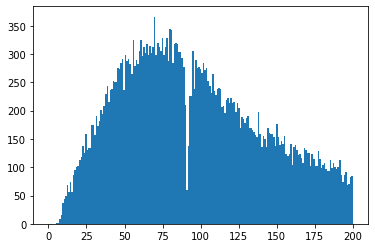

In [222]:
bins = np.linspace(0, 200, 200)
plt.hist(df_z_cand_masses["ZCand_mass_1"].dropna().values, bins=bins)
plt.show()